# Neoclassical transport for an axisymmetric plasma

Currently a work in progress.

# Houlberg_1997

Equation 6:

$$F_\alpha^{ai} = \int m_a v L_{\alpha-1}^{3/2}(x_a^2)C_{ai} dv$$


$$<F_\alpha^{ai} \cdot B> = \sum_{b,j,\beta} l_{\alpha \beta}^{ai, bj} \hat{u}_\beta^{bj}$$


$$l_{\alpha \beta} ^{ai, bj} = \xi_{ai}(\delta_{ai,bj} M_{\alpha\beta}^a + \xi_{bj} N_{\alpha \beta}^{ab})$$

$$\xi_{ai} = n_{ai} Z_i^2 / \sum_i n_{ai} Z_i^2$$

$$\mu_{\alpha \beta}^{ai} = \frac{8}{3 \sqrt\pi} n_{ai} m_a (-1)^{\alpha + \beta} \times \int_0^\infty dx x^4 e^{-x^2} L_{\alpha-1}^{3/2} L_{\beta-1}^{3/2} \bar{K}^{ai}$$

$$\bar{K}^{ai} = K_B K_{PS} / (K_B + K_{PS})$$
(upuściłem superskrypt ai wszędzie);
$K_B, K_{PS}$ zdefiniowane w appendix B

Equation 23:

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

Eventually we can go back to $$D^{C,\alpha} = \frac{- \Gamma^{C,\alpha}}{n_c \nabla(\ln \alpha)}$$

for $\alpha \in \{ T_e, T_i, n_e, n_D, n_C \}$

Eq. 41a:

$$\Gamma_{BP}^{ai} = -\hat{F} e_{ai}^{-1} \sum_\beta \hat{\mu}_{1\beta}^{ai} \hat{u}_{\theta,\beta}^{ai}$$

And the other gammas... around eq. 43

TODO assume we can skip heat flows for now. That's 41b

In [1]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
a = all_species["H"]
i = 1
ai = a[i]
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [2]:
h1 = all_species["H"][1]
h1.number_density, h1.T_i

(<Quantity 1.e+20 1 / m3>, <Quantity 116045.1812155 K>)

# Flux surface

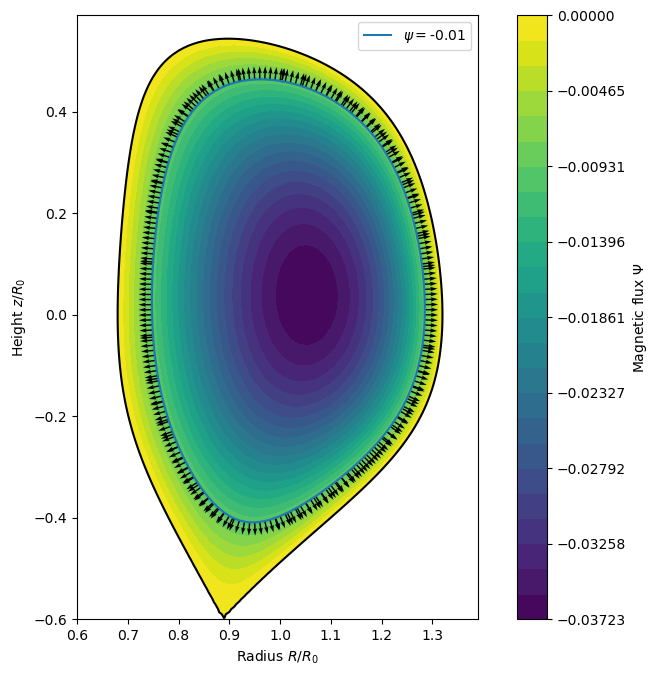

In [3]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot()
fs = flux_surface = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True);

# Appendix B

### F_m and its unknown values

0.01110030302773168

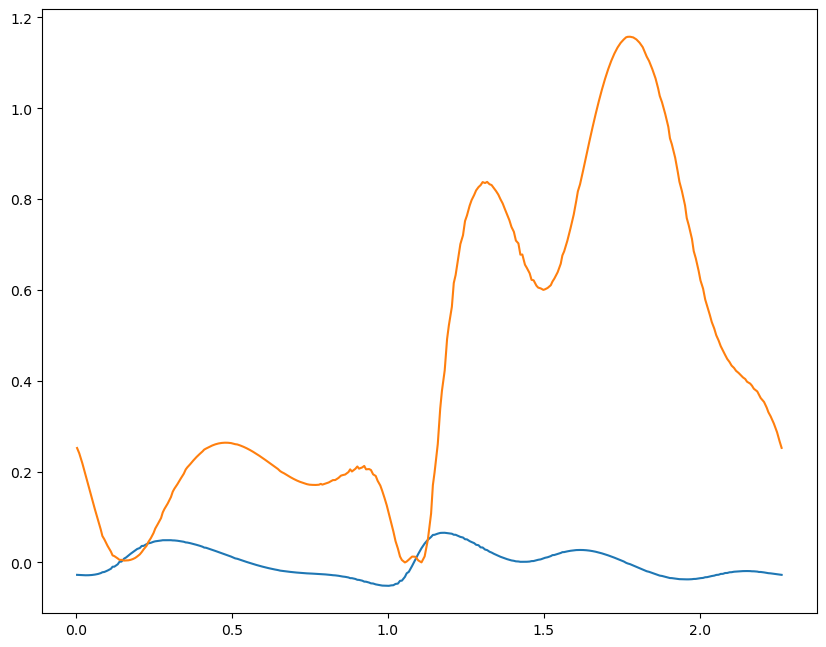

In [4]:
Theta = fs.Theta
B20 = fs.Brvals * fs.Bprimervals + fs.Bzvals * fs.Bprimezvals
plt.plot(fs.lp, B20)

# B17
Bprimevectors = np.stack((fs.Bprimervals, fs.Bprimezvals))

under_average_B17 = np.array(
    [np.dot(ni, Bpi) ** 2 for (ni, Bpi) in zip(fs.n.T, Bprimevectors.T)]
)
plt.plot(fs.lp, under_average_B17)
B2mean = fs.flux_surface_average(fs.B2)
B17 = fs.flux_surface_average(under_average_B17) / B2mean


In [5]:
num_m = 1000


from plasmapy.formulary.neoclassical import F_m

def optimizer(g):
    mrange = range(1, num_m)
    F_ms = np.array([F_m(m, fs, g) for m in mrange])
    diff = F_ms.sum() - B17
    return diff ** 2


from scipy import optimize

optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, fs, optimization.x) for m in mrange])

array([3.18057562e-06, 1.09106369e-03, 4.33291622e-05, ...,
       2.00629745e-05, 4.09600905e-06, 4.55589872e-06])

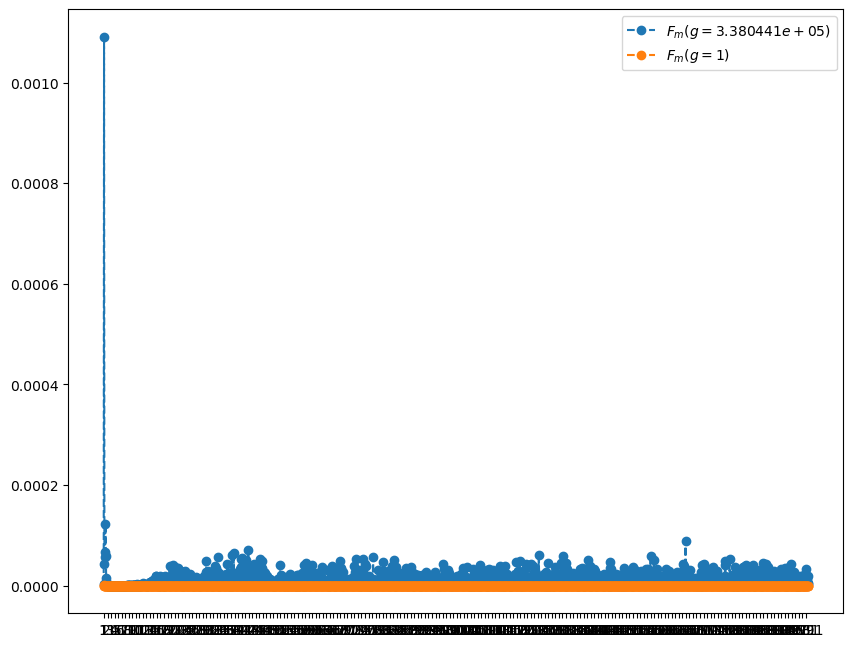

In [6]:
plt.plot(F_ms, "o--", label=fr"$F_m(g={optimization.x:e})$")
plt.plot(np.array([F_m(m, fs, 1) for m in mrange]), "o--", label=r"$F_m(g=1)$")
plt.xticks(mrange[::10])
plt.legend()

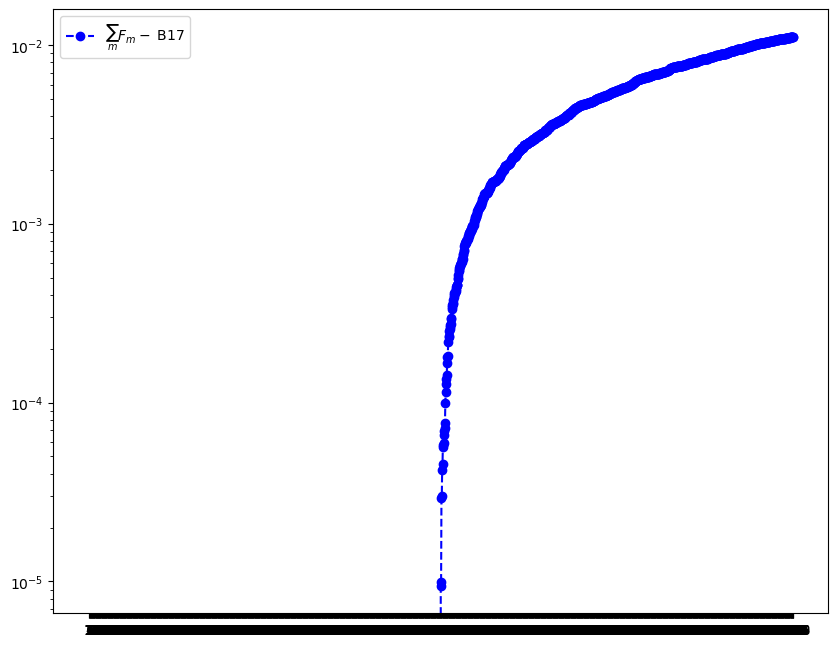

In [7]:
cumsum = np.cumsum(F_ms)

plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
plt.yscale("log")
plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [8]:
from plasmapy.formulary.neoclassical import K_ps_ai


K_ps_ai(1, 1, a, all_species, fs, g=optimization.x, m_max = 100)

(100,) (100, 1)
full_sum=<Quantity [0.00198634] s>


<Quantity [5703948.49771724] 1 / s>

In [9]:
from plasmapy.formulary.neoclassical import K_B_ai

In [10]:
K_B_ai(1, 1, a, all_species, fs)

<Quantity 10340684.63637584 1 / s>

$$[K_B^{ai}] = \frac{1}{1} \frac{[\nu_{D,ai}]}{1}$$

$$[\nu_{D,ai}] = s^{-1}$$

In [11]:
from plasmapy.formulary.neoclassical import ν_T_ai

ν_T_ai(1, 1, a, all_species)

<Quantity 24638301.15254432 1 / s>

In [12]:
from plasmapy.formulary.neoclassical import mu_hat, ωm

In [13]:
from plasmapy.formulary import thermal_speed

## \nu_T_ai

In [14]:
from plasmapy.formulary.neoclassical import ξ, xab_ratio, effective_momentum_relaxation_rate
from scipy.special import erf

from plasmapy.formulary import thermal_speed
from plasmapy.formulary.mathematics import Chandrasekhar_G


x = np.logspace(-3, 6, 5000)                                                          

ai = a[i]
prefactor = 3 * np.pi ** 0.5 / 4 * ξ(a)[i] / ai.number_density / ai.ion.mass

def gen():
    for b in all_species:
        if b.base_particle != a.base_particle:  # TODO is not should work
            x_over_xab = x / xab_ratio(a, b).si.value
            part1 = erf(x_over_xab) - 3 * Chandrasekhar_G(x_over_xab) / x ** 3
            part2 = 4 * (
                a.T_e / b.T_e + xab_ratio(a, b) ** -2
            )  # TODO adjust ratios
            part2full = part2 * Chandrasekhar_G(x_over_xab) / x
            yield (part1 + part2full) * effective_momentum_relaxation_rate(a, b)

result = prefactor * sum(gen())

<Quantity [-3.15477856e+13, -3.12872990e+13, -3.10289631e+13, ...,
            8.09962829e+06,  8.09962829e+06,  8.09962829e+06] 1 / s>

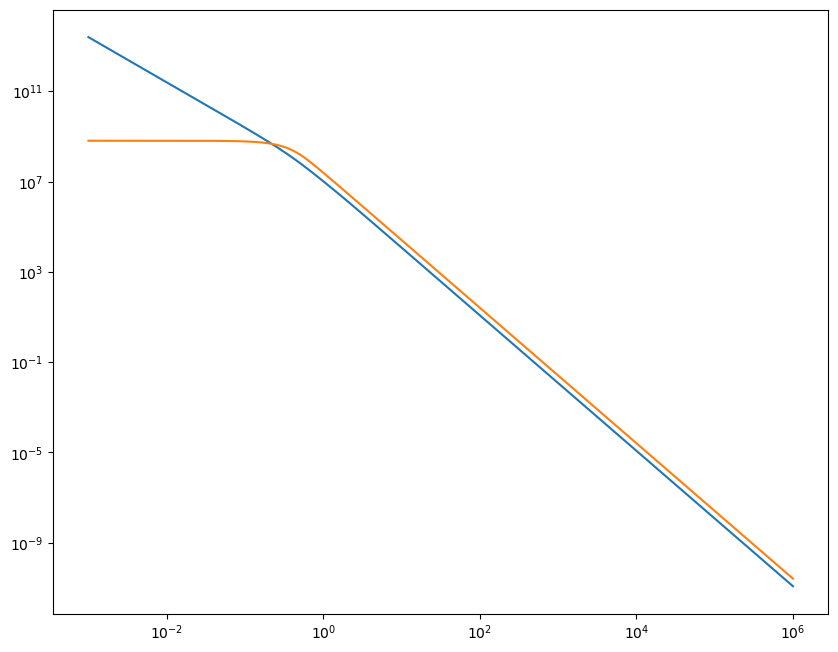

In [15]:
from plasmapy.formulary.neoclassical import pitch_angle_diffusion_rate, K_B_ai
from plasmapy.formulary.mathematics import Chandrasekhar_G
x = np.logspace(-3, 6, 5000)                                                          
ν_D_ai = pitch_angle_diffusion_rate(x, 1, a, all_species)                 
k = K_B_ai(x, 1, a, all_species, flux_surface)  
g = Chandrasekhar_G(x)
plt.loglog(x, k)
x = np.logspace(-3, 6, 5000)                                                          
plt.loglog(x, ν_T_ai(x, i, a, all_species))

In [16]:
187876905349248.0 / 280385118629590976.0

0.0006700673212170257

## K_ps_ai

(100,) (100, 5000)
full_sum=<Quantity [ 3.90160271e+05,  4.12181803e+03, -1.25027579e+05, ...,
            1.49814369e-13,  1.49194602e-13,  1.48577398e-13] s>


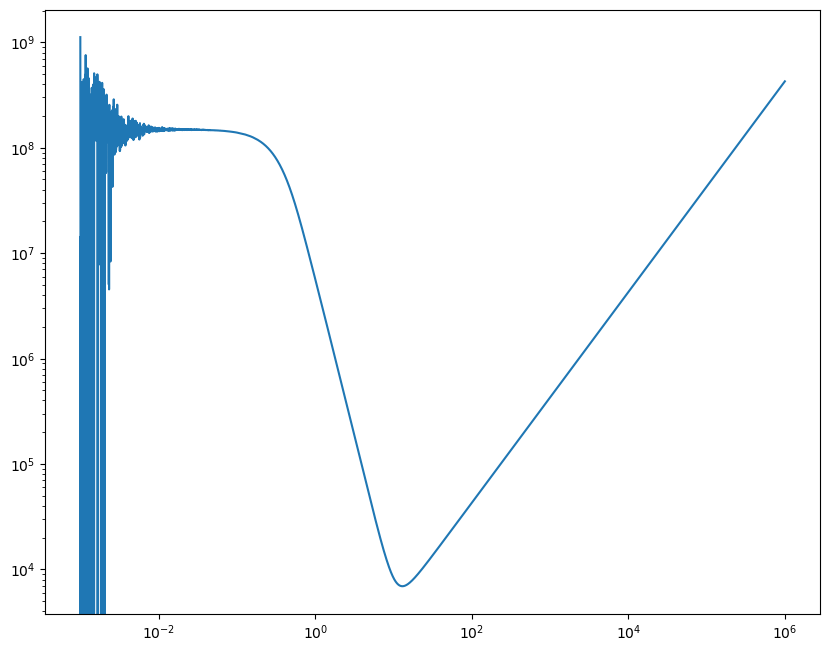

In [17]:
ai = a[i]
ν = ν_T_ai(x, i, a, all_species)

flux_surface = fs
g = optimization.x
m_max = 100
m = np.arange(1, m_max + 1)
F = F_m(m[:, np.newaxis], flux_surface, g=g)  # TODO replace
ω = ωm(x, m[:, np.newaxis], a, flux_surface)
B10 = (
    1.5 * (ν / ω) ** 2
    - 9 / 2 * (ν / ω) ** 4
    + (1 / 4 + (3 / 2 + 9 / 4 * (ν / ω) ** 2) * (ν / ω) ** 2)
    * (2 * ν / ω)
    * np.arctan(ω / ν).si.value
)
print(F.shape, B10.shape)
onepart = F[:, np.newaxis] * B10
full_sum = np.sum(onepart / ν, axis=0)
print(f"{full_sum=}")

out = (
    3
    / 2
    * thermal_speed(a.T_e, a.base_particle) ** 2
    * x ** 2
    * full_sum
    / u.m ** 2
)

plt.loglog(x, out)

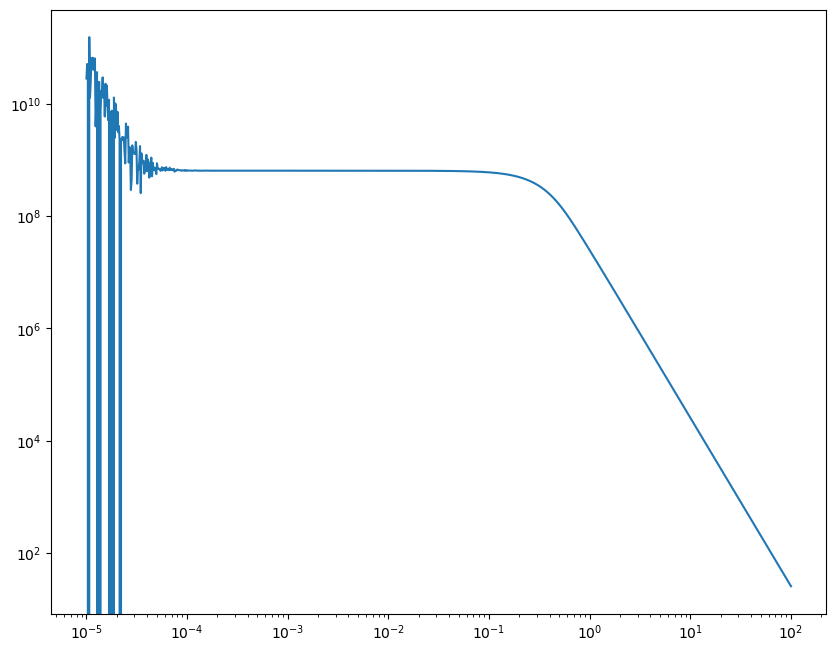

In [18]:
Y = np.logspace(-5, 2, 1000)
ν = ν_T_ai(Y, i, a, all_species)
plt.loglog(Y, ν)

In [19]:
ν_T_ai(Y[ν < 0][0], i, a, all_species)

<Quantity -3.66288921e+10 1 / s>

In [20]:
ν_T_ai(0.1, i, a, all_species)

<Quantity 6.01347211e+08 1 / s>

got kb=<Quantity [2.49960933e+19, 2.48921059e+19, 2.47902053e+19, ...,
           1.20362250e-02, 1.19616208e-02, 1.18874789e-02] 1 / s>
(100,) (100, 10000)
full_sum=<Quantity [2.79478983e+35, 6.84884031e+32, 2.07344617e+36, ...,
           1.49194541e-10, 1.48885650e-10, 1.48577399e-10] s>
got kps=<Quantity [8.02548290e+32, 1.97487330e+30, 6.00364693e+33, ...,
           4.24888122e+05, 4.25769630e+05, 4.26652967e+05] 1 / s>
(100,) (100, 10000)
full_sum=<Quantity [2.79478983e+35, 6.84884031e+32, 2.07344617e+36, ...,
           1.49194541e-10, 1.48885650e-10, 1.48577399e-10] s>


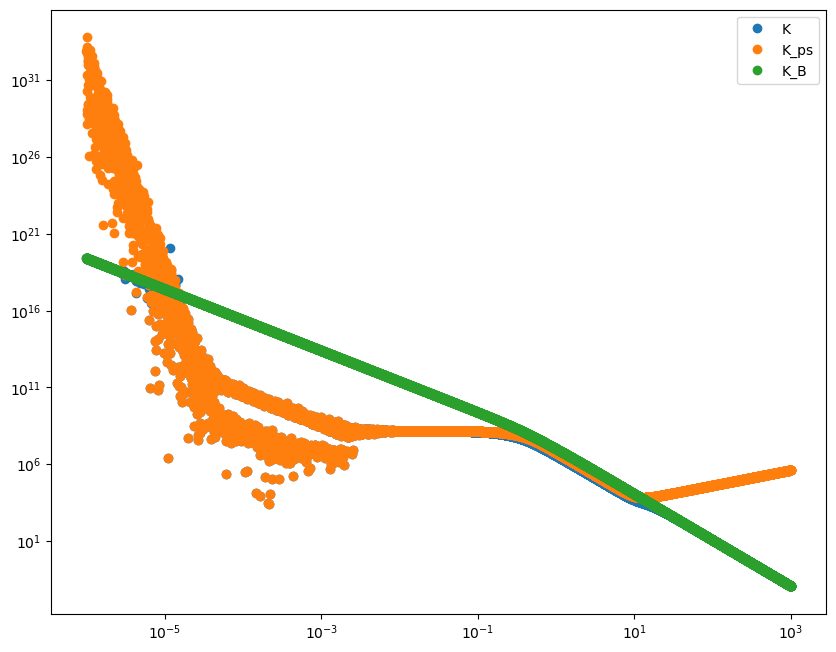

In [22]:
from plasmapy.formulary.neoclassical import K
x = np.logspace(-6, 3, 10000)
kout = K(x, 1, a, all_species, fs, g = optimization.x)
kpout = K_ps_ai(x, 1, a, all_species, fs, g = optimization.x,)
kbout = K_B_ai(x, 1, a, all_species, fs)
plt.loglog(x, kout, "o", label="K")
plt.loglog(x, kpout, "o", label="K_ps")
plt.loglog(x, kbout, "o", label="K_B")
plt.legend()
plt.savefig("/tmp/wtf.png")

In [23]:
from scipy import integrate

In [24]:
integrate.quad(lambda *args: K_B_ai(*args).value, 0, 1, args=(1, a, all_species, fs))

<ipython-input-24-17a9f172fab0>:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(lambda *args: K_B_ai(*args).value, 0, 1, args=(1, a, all_species, fs))


(-58957379.27063876, 264.18996142596006)

(100,) (100, 1000)
full_sum=<Quantity [-8.24093795e+17,  3.71393669e+12, -4.33110428e+16,
            9.16488446e+19, -1.85824460e+16,  3.37216199e+11,
           -5.37378366e+14, -2.47373921e+15, -8.88205972e+19,
            1.42839455e+18, -3.83126267e+18,  2.01320555e+16,
           -4.62532977e+15, -1.20141938e+18, -1.02372868e+14,
           -2.03683813e+16, -1.97244059e+16,  3.43819578e+18,
           -8.15353498e+17, -9.35611261e+18,  9.38765001e+16,
           -1.09671773e+16, -5.79931024e+18,  2.34154043e+14,
            2.40012990e+15, -3.49397038e+18,  1.25930104e+18,
           -8.05592387e+15,  1.14992964e+19,  2.40315467e+17,
            3.10858134e+16,  5.59378561e+18,  3.70541584e+12,
           -7.88519688e+13, -1.41595095e+16,  6.54554985e+15,
            1.48631574e+15,  1.35277791e+17,  6.41335356e+17,
            7.15636814e+13,  6.88021183e+12, -1.04737343e+16,
           -2.33911686e+17,  2.97777070e+16,  6.51482734e+12,
           -2.60888909e+14, -7.32827191e+1

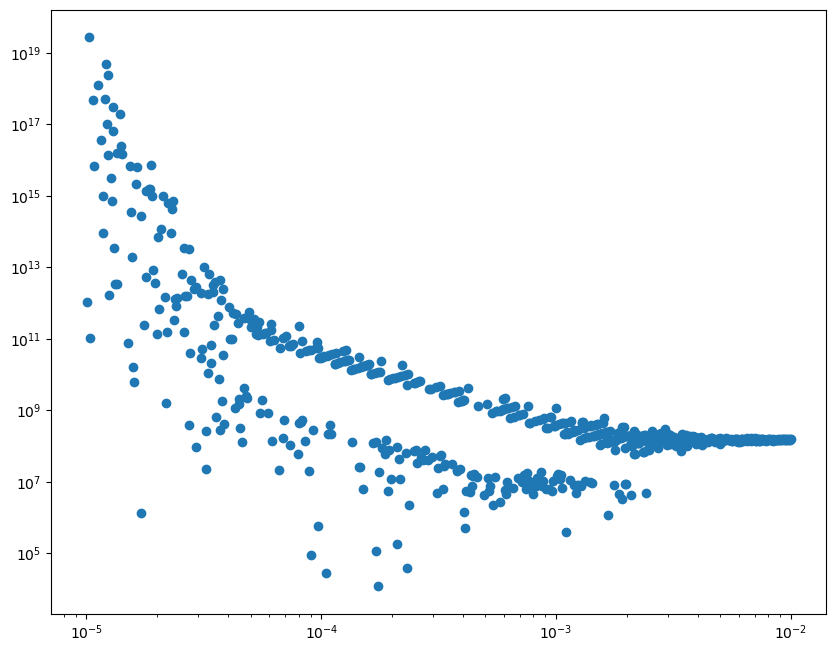

In [26]:
Y = np.logspace(-5, -2, 1000)
kpout = K_ps_ai(Y, 1, a, all_species, fs, g = optimization.x,)
plt.loglog(Y, kpout, "o", label="K_ps")

In [ ]:
mu_hat(1, a, all_species, fs, g = optimization.x)

Integrating for (α, β)=(1, 1)
got kb=<Quantity 10340684.63637584 1 / s>
(100,) (100, 1)
full_sum=<Quantity [0.00198634] s>
got kps=<Quantity [5703948.49771724] 1 / s>
got kb=<Quantity 0.93898011 1 / s>
(100,) (100, 1)
full_sum=<Quantity [6.37493938e-10] s>
got kps=<Quantity [99438.10175184] 1 / s>
got kb=<Quantity 1.35768444e+12 1 / s>
(100,) (100, 1)
full_sum=<Quantity [3556.90542274] s>
got kps=<Quantity [1.88035387e+08] 1 / s>
got kb=<Quantity 211.58468334 1 / s>
(100,) (100, 1)
full_sum=<Quantity [3.88786054e-09] s>
got kps=<Quantity [16375.8530852] 1 / s>
got kb=<Quantity 3.6609153e+10 1 / s>
(100,) (100, 1)
full_sum=<Quantity [76.24431528] s>
got kps=<Quantity [1.49265091e+08] 1 / s>
got kb=<Quantity 4519.40746912 1 / s>
(100,) (100, 1)
full_sum=<Quantity [1.27238761e-08] s>
got kps=<Quantity [6958.19476961] 1 / s>
got kb=<Quantity 4.70648165e+09 1 / s>
(100,) (100, 1)
full_sum=<Quantity [9.53420533] s>
got kps=<Quantity [1.43764411e+08] 1 / s>
got kb=<Quantity 38720.64786231 1 /